In [27]:

from keras.utils import to_categorical
from keras.optimizers import Adam, Adadelta, SGD
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten, Conv1D, GlobalAveragePooling1D, Convolution1D
from keras.layers.convolutional import MaxPooling2D, MaxPooling1D
from keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import class_weight
from scipy import signal
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# constants:
SUBSAMPLE = 100  # scales the data by this factor can be replaced by divding the steps per epoch by batch size
COLUMNS = ['HandStart', 'FirstDigitTouch',
        'BothStartLoadPhase', 'LiftOff',
        'Replace', 'BothReleased']
SUBJECTS = range(1, 2)
N_LABELS = 6

# Below are the paths to the data. Please pay attention to the % and * signs, these are needed in the loop.
TRAIN_DATA_PATH = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/Datasets/EEG/train/subj%d_series*_data.csv'
#The path below is for the test data used for a kaggle submission. This is not very relevant to our project.
# TEST_DATA_PATH = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/Datasets/EEG/test/subj%d_series*_data.csv'
# TRAIN_DATA_PATH = 'C:/Users/bas/Documents/MachineLearning/train/subj%d_series*_data.csv' #path on my laptop
# TEST_DATA_PATH =  'C:/Users/bas/Documents/MachineLearning/test/subj%d_series*_data.csv' 

SUBMISSION_FOLDER = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/'
SUBMISSION_NAME = 'subbmision_vu_48_sub_pca_4.csv'

PCA_COMPONENTS = 0.8
CUTT_OFF_FREQUENCY = 2
ORDER = 4
SAMPLE_FREQUENCY = 500

EPOCHS = 5
WINDOW_SIZE = 1000

In [3]:
def prepare_training_data(data_path):
    data = pd.read_csv(data_path)
    event_path = data_path.replace('_data', '_events')
    labels = pd.read_csv(event_path)
    clean_data = data.drop(['id'], axis = 1)
    labels = labels.drop(['id'], axis = 1)
    return clean_data, labels

In [4]:
def prepare_test_data(data_path):
    data = pd.read_csv(data_path)
    return data

In [26]:
# def scaler_transform(data, scaler):
#     if scaler == None:
#         scaler = StandardScaler(with_mean=True, with_std=True)
#         return scaler.fit_transform(data), scaler
#     else:
#         return scaler.transform(data)  
    
def scaler_transform(data, scaler):
    if scaler == None:
        scaler = Normalizer()
        return scaler.fit_transform(data), scaler
    else:
        return scaler.transform(data)   

In [6]:
def read_training_data(train_data_paths):
    labels_raw = []
    features_raw = []
    for data_path in train_data_paths:
        data, labels = prepare_training_data(data_path)
        features_raw.append(data)
        labels_raw.append(labels)
    features_raw = pd.concat(features_raw)
    labels_raw = pd.concat(labels_raw)
    x_train = np.asarray(features_raw.astype(float))
    y_train = np.asarray(labels_raw.astype(float))
    return x_train, y_train

In [7]:
def read_test_data(test_data_paths):
    test_features_raw = []
    ids = []
    for data_path in test_data_paths:
        data = prepare_test_data(data_path)
        test_features_raw.append(data)
        ids.append(np.array(data['id']))
    test_features_raw = pd.concat(test_features_raw)
    ids = np.concatenate(ids)
    test_features_raw = test_features_raw.drop(['id'], axis = 1)
    x_test = np.asarray(test_features_raw.astype(float))
    return x_test, ids

In [8]:
def metric_auc_score(predictions, y_test, with_plot):
    scores = []
    legend_text = []
    for i in range(N_LABELS):
        fpr, tpr, _  = roc_curve(y_test[:,i], predictions[:,i], 1)
        scores.append(roc_auc_score(y_test[:,i], predictions[:,i]))
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (scores[i]))
        if with_plot == True:
            plt.plot(fpr, tpr)
    if with_plot == True:
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
        plt.show()
    return scores

In [9]:
def single_metric_auc_score(predictions, y_test, with_plot):
    fpr, tpr, _  = roc_curve(y_test, predictions, 1)
    score = roc_auc_score(y_test, predictions)
    print(COLUMNS[0]+' AUC score = %.3f' % (score))
    if with_plot == True:
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.show()
    return score

In [10]:
def all_auc_scores(prediction_total, test_data_total, subjects, with_plot):
    scores = []
    for subject in subjects:
        score = metric_auc_score(prediction_total[subject-1],
                                 test_data_total[subject-1], with_plot)
        scores.append(score)
        print('Mean AUC Score of Subject %d: %.3f' % \
              (subject, np.mean(score)))
    return scores

In [11]:
# def image_mappping(x_train, WINDOW_SIZE):
#     result = []
#     empty_matrix = np.atleast_3d(np.zeros(np.shape(x_train[0:WINDOW_SIZE])))
#     for i in range(len(x_train)):
#         if i-WINDOW_SIZE < 0:
#             result.append(empty_matrix)
#         else:
#             result.append(np.atleast_3d(x_train[i-WINDOW_SIZE:i]))
#     return result

def image_mappping(x_train, WINDOW_SIZE):
    result = []
    empty_matrix = np.zeros(np.shape(x_train[0:WINDOW_SIZE]))
    for i in range(len(x_train)):
        if i-WINDOW_SIZE < 0:
            result.append(empty_matrix)
        else:
            result.append(x_train[i-WINDOW_SIZE:i])
    return result

In [12]:
def resample_and_shuffle(labels):
    when_task = np.where(labels[:,1] == 1)
    when_no_task = np.where(labels[:,1] == 0)
    when_no_task = when_no_task[0][0:len(when_task[0])]
    indices = np.concatenate([when_task[0], when_no_task])
    np.random.shuffle(indices)
    return indices

def train_generator(x_train, y_train, WINDOW_SIZE, batch_size):
    x = image_mappping(x_train, WINDOW_SIZE)
    indices = resample_and_shuffle(y_train)
    while True:
        images = []
        tasks = []
        for i, index in enumerate(indices):
            images.append(x[index])
            tasks.append(y_train[index])
            if (i+1) % batch_size == 0:
                yield np.array(images), np.array(tasks)
                images = []
                tasks = []
            if i == len(indices)-1:
                yield np.array(images), np.array(tasks)

In [19]:
def test_generator(x_train, WINDOW_SIZE, batch_size):
    x = image_mappping(x_train, WINDOW_SIZE)
    while True:
        images = []
        tasks = []
        for i in range(len(x)):
            images.append(x[i])
            if (i+1) % batch_size == 0:
                yield np.array(images)
                images = []
                tasks = []
            if i == len(x)-1:
                yield np.array(images)             
                

# def test_generator(x_test, WINDOW_SIZE):
#     x = image_mappping(x_test, WINDOW_SIZE)
#     while True:
#         for image in x:
#             yield np.array([image])

In [14]:
def class_weights(y_train):
    class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train[:,0]), y_train[:,0])
    return {0 : class_weight[1], 2: class_weight[0]}

In [15]:
def init_cnn(window):


    model = Sequential()
    model.add(Conv1D(nb_filter=16, filter_length=3, activation='relu', input_shape=(window, 32)))
    model.add(MaxPooling1D(3,2))
    model.add(Conv1D(nb_filter=32, filter_length=3, activation='relu'))
    model.add(Conv1D(nb_filter=64, filter_length=3, activation='relu'))
    model.add(MaxPooling1D(3,2))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.summary()
    
    optimizer = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
#     optimizer = Adam(lr=1e-6)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [28]:
for subject in SUBJECTS:
    test_features_raw = []
    train_data_paths = glob(TRAIN_DATA_PATH % (subject))
  
    x_train, y_train = read_training_data(train_data_paths)  
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)
    
    x_train, scaler = scaler_transform(x_train, None)
    x_test = scaler_transform(x_test, scaler)
    
    train_labels = to_categorical(y_train[:,0], num_classes = None)
    test_labels = to_categorical(y_test[:,0], num_classes = None)

#     class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train[:,0]), y_train[:,0])
#     class_weights = {0 : 1., 1: class_weights[0], 2: class_weights[1]}
    
    


In [29]:
model = init_cnn(window=WINDOW_SIZE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 998, 16)           1552      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 498, 16)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 496, 32)           1568      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 494, 64)           6208      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 246, 64)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 246, 64)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 246, 128)          8320      
__________

In [ ]:
indices = resample_and_shuffle(train_labels)
test_indices = resample_and_shuffle(test_labels)
BATCH_SIZE = 50

my_generater = train_generator(x_train, train_labels, WINDOW_SIZE, BATCH_SIZE)
my_val_generater = train_generator(x_test, test_labels, WINDOW_SIZE, BATCH_SIZE)

model.fit_generator(my_generater, steps_per_epoch=len(indices)/BATCH_SIZE, epochs=30, verbose=1,
                    validation_data=my_val_generater, validation_steps=len(test_indices)/BATCH_SIZE)

Epoch 1/30
1087/1086 [==============================] - 44s 40ms/step - loss: 0.6930 - acc: 0.5108 - val_loss: 0.6924 - val_acc: 0.5004
Epoch 2/30
1087/1086 [==============================] - 42s 38ms/step - loss: 0.6928 - acc: 0.5119 - val_loss: 0.6912 - val_acc: 0.5029
Epoch 3/30
1087/1086 [==============================] - 41s 38ms/step - loss: 0.6919 - acc: 0.5138 - val_loss: 0.6904 - val_acc: 0.5012
Epoch 4/30
1087/1086 [==============================] - 39s 36ms/step - loss: 0.6917 - acc: 0.5109 - val_loss: 0.6893 - val_acc: 0.4992
Epoch 5/30
 507/1086 [=============>................] - ETA: 17s - loss: 0.6912 - acc: 0.5142

In [22]:
my_test_generater = test_generator(x_test, WINDOW_SIZE, BATCH_SIZE)
predictions = model.predict_generator(my_test_generater, steps=len(x_test)/BATCH_SIZE)

HandStart AUC score = 0.504


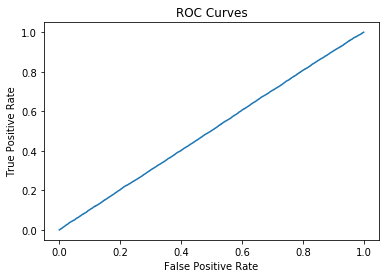

0.5035783710229542

In [31]:
single_metric_auc_score(predictions[:,1], test_labels[:,1], True)

In [ ]:
score = single_metric_auc_score(predictions[:, 1], test_labels[:,1][::10], True)
print('AUC score: %.3f' % (score))

0
50
100
150
200
250
300
350
400
450
